In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import random
from skimage import draw, io
from skimage.draw import polygon
from skimage.draw import polygon_perimeter
from math import pi, acos
import math
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, jaccard_similarity_score
from sklearn.utils.fixes import signature
from sklearn.utils import shuffle

# Generation of Data

### Some functions for Image Generation

In [2]:
### Rotate a point 'X' by an angle 'angle' 
def rotation(X, angle):
    X = np.asarray(X)
    assert X.size == 2
    rad = math.radians(angle)
    return np.array((X[0]*math.cos(rad)+X[1]*math.sin(rad), -X[0]*math.sin(rad)+X[1]*math.cos(rad)))

In [3]:
### Generate a rectangle
def make_rectangle(width,height,dim,rotation_angle=0,input_data=1):
    """
    return a rectangle centered at (half_dim,half_m) with the left upper vertex (x_left,y_upper)
    if ratation_angle is not 0, then the rectangle is rotated by rotation_angle around the center
    """
    # 함수의 변수가 적절한지 판단
    half_dim = math.trunc(dim/2)
#     assert width < half_dim and height < half_dim
    
    vertices = [rotation((math.trunc(height/2),math.trunc(width/2)),rotation_angle),
                rotation((-math.trunc(height/2),math.trunc(width/2)),rotation_angle),
                rotation((-math.trunc(height/2),-math.trunc(width/2)),rotation_angle),
                rotation((math.trunc(height/2),-math.trunc(width/2)),rotation_angle)]
                
    
    vertices = np.asarray(vertices) + dim / 2
    
    image = np.zeros((dim,dim))
    rr, cc = draw.polygon(vertices[:,0], vertices[:,1]) 
    image[rr, cc] = input_data
    
    return image

In [4]:
### Generate a perimeter(random mix of -1 and +1)
def make_perimeter_random(width,height,dim,rotation_angle=0):
    
    half_dim = math.trunc(dim/2)
    
    vertices = [rotation((math.trunc(height/2),math.trunc(width/2)),rotation_angle),
                rotation((-math.trunc(height/2),math.trunc(width/2)),rotation_angle),
                rotation((-math.trunc(height/2),-math.trunc(width/2)),rotation_angle),
                rotation((math.trunc(height/2),-math.trunc(width/2)),rotation_angle)]

    vertices = np.asarray(vertices) + dim / 2
    
    image = np.zeros((dim,dim))
    rr, cc = polygon_perimeter(vertices[:,0], vertices[:,1]) 
    image[rr, cc] = np.random.choice([-1,1], size = len(rr))
    
    return image

### Set up the structure of the data

In [5]:
dim = 50 # the width and height of the image
half_dim = int(dim / 2)
no_targets = 80  # the number of targets
no_ligands = 1000  # the number of liands
shapes = ['rec','tri','elli','star']
no_shapes = len(shapes)
Jaccard_cutoff = 0.5

In [6]:
# Target & Ligand Images: image + identifier(1:target; 0:ligand)
# np.zeros((Batch, Height, Width, Channel))
images = np.zeros((no_ligands*no_targets,dim,dim*2,2),dtype='int8')
results = np.zeros((no_ligands*no_targets,1),dtype='int8')
target_heights = []
ligand_heights_widths = []
Jaccard_similarity_scores = ['mismatch']*(no_ligands*no_targets)

In [7]:
# Target image generation 
for i in range(no_targets):
    
    # set target variables
    target_width = random.randint(5, half_dim)
    target_height = random.randint(5, half_dim)
    target_rotation = 0 #random.randint(0, 90)
    
    # a channel representing structure(present=1 / absent=0)
    images[i*no_ligands:(i+1)*no_ligands,:,:dim,0] = 1 - make_rectangle(target_width, target_height, dim, target_rotation)
    images[i*no_ligands:(i+1)*no_ligands,:,half_dim:dim,0] = 0
    
    # a channel representing charge(positive=+1 /negative=-1)
    # 1 added to width/height to expand to the edge
    images[i*no_ligands:(i+1)*no_ligands,:,:dim,1] = make_perimeter_random(target_width+2, target_height+2, dim, target_rotation)
    images[i*no_ligands:(i+1)*no_ligands,:,half_dim:dim,1] = 0
    
    # Ligand image generation
    for j in range(no_ligands):    
        
        #set ligand variables
        ligand_width = random.randint(5, half_dim)
        ligand_height = random.randint(5, half_dim)
        ligand_rotation = 0 #random.randint(0, 90)
            
        # a channel representing structure(present=1 / absent=0)
        images[i*no_ligands+j:i*no_ligands+(j+1),:,dim:,0] = make_rectangle(ligand_width, ligand_height, dim, ligand_rotation)
            
        # a channel representing charge(positive=+1 /negative=-1)
        images[i*no_ligands+j:i*no_ligands+(j+1),:,dim:,1] = make_perimeter_random(ligand_width, ligand_height, dim, ligand_rotation)
        
        # trim zero padding off target/ligand for easier comparison of the target/ligand pair
        target_compress = images[i*no_ligands+j:i*no_ligands+(j+1),:,:dim,1][0]
        target_compress_2 = target_compress[~np.all(target_compress == 0, axis=1)]
        target_compress_3 = target_compress_2[:,~np.all(target_compress_2 == 0, axis=0)]
        
        ligand_compress = images[i*no_ligands+j:i*no_ligands+(j+1),:,dim:,1][0]
        ligand_compress_2 = ligand_compress[~np.all(ligand_compress == 0, axis=1)]
        ligand_compress_3 = ligand_compress_2[:,~np.all(ligand_compress_2 == 0, axis=0)]
        
        # Jaccard similarity score calculation(for each edge)
        binding_site_concat = np.concatenate((target_compress_3[0,1:],target_compress_3[1:-1,0],target_compress_3[-1,1:]))
        
        edge_1 = ligand_compress_3[:,:(len(target_compress_3[0])-1)]
        edge_1_concat = np.concatenate((edge_1[0,:],edge_1[:,0],edge_1[-1,:]))
        
        edge_2 = np.rot90(ligand_compress_3[:,-(len(target_compress_3[0])-1):],2)
        edge_2_concat = np.concatenate((edge_2[0,:],edge_2[:,0],edge_2[-1,:]))
        
        edge_3 = np.rot90(ligand_compress_3[:(len(target_compress_3[0])-1),:],1)
        edge_3_concat = np.concatenate((edge_3[0,:],edge_3[:,0],edge_3[-1,:]))
        
        edge_4 = np.rot90(ligand_compress_3[-(len(target_compress_3[0])-1):,:],3)
        edge_4_concat = np.concatenate((edge_4[0,:],edge_4[:,0],edge_4[-1,:]))
        
        # active/inactive criteria
        target_heights.append(len(target_compress_3[:,0])-2)
        ligand_heights_widths.append([len(ligand_compress_3[:,0]), len(ligand_compress_3[0,:])])
        
        # label the activity of each Target and Ligand pair        
        if len(target_compress_3[:,0])-2 == len(ligand_compress_3[:,0]):
            if len(binding_site_concat) == len(edge_1_concat):
                score_1 = jaccard_similarity_score(binding_site_concat, -edge_1_concat)
                score_2 = jaccard_similarity_score(binding_site_concat, -edge_2_concat)
                if score_1 > Jaccard_cutoff or score_2 > Jaccard_cutoff:
                    results[i*no_ligands+j] = 1
                    Jaccard_similarity_scores[i*no_ligands+j] = [score_1, score_2]
                else:
                    results[i*no_ligands+j] = 0
                    Jaccard_similarity_scores[i*no_ligands+j] = [score_1, score_2]

        if len(target_compress_3[:,0])-2 == len(ligand_compress_3[0,:]):
            if len(binding_site_concat) == len(edge_3_concat):
                score_3 = jaccard_similarity_score(binding_site_concat, -edge_3_concat)
                score_4 = jaccard_similarity_score(binding_site_concat, -edge_4_concat)
                if score_3 > Jaccard_cutoff or score_4 > Jaccard_cutoff:
                    results[i*no_ligands+j] = 1
                    Jaccard_similarity_scores[i*no_ligands+j] = [score_3, score_4]
                else:
                    results[i*no_ligands+j] = 0
                    Jaccard_similarity_scores[i*no_ligands+j] = [score_3, score_4]
                
        else:
            results[i*no_ligands+j] = 0

In [8]:
target_height

25

In [9]:
len(target_compress_3[:,0])-2

25

In [10]:
ligand_width, ligand_height

(15, 14)

In [11]:
len(ligand_compress_3[:,0])

15

In [12]:
# no. of inactives, actives 
print("Inactive: " + str(len(results) - results.sum()))
print("Active: " + str(results.sum()))

Inactive: 75146
Active: 4854


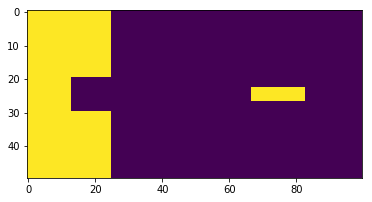

In [13]:
plt.imshow(images[18,:,:,0])

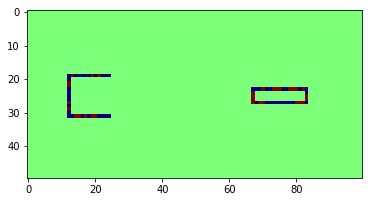

In [14]:
plt.imshow(images[18,:,:,1], cmap='jet')

In [15]:
results[18]

array([0], dtype=int8)

# Preparation for CNN

In [16]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.13.1


In [17]:
images = images
results = results
target_criteria_size = target_heights
ligand_criteria_size = ligand_heights_widths
Jaccard_criteria = Jaccard_similarity_scores

print("result shape = " + str(results.shape))

class_names = ['inactive','active']

result shape = (80000, 1)


In [18]:
# Train set
index_train_data = random.sample(range(0,no_ligands*no_targets),int(no_ligands*no_targets*0.8))
train_images = np.asarray([images[i] for i in index_train_data])
train_labels = np.asarray([results[i] for i in index_train_data])
train_target_criteria_size = np.asarray([target_criteria_size[i] for i in index_train_data])
train_ligand_criteria_size = np.asarray([ligand_criteria_size[i] for i in index_train_data])
train_Jaccard_criteria = np.asarray([Jaccard_criteria[i] for i in index_train_data])

# Test set
index_test_data = list(set(range(no_ligands*no_targets)).difference(set(index_train_data)))
test_images = np.asarray([images[i] for i in index_test_data])
test_labels = np.asarray([results[i] for i in index_test_data])
test_target_criteria_size = np.asarray([target_criteria_size[i] for i in index_test_data])
test_ligand_criteria_size = np.asarray([ligand_criteria_size[i] for i in index_test_data])
test_Jaccard_criteria = np.asarray([Jaccard_criteria[i] for i in index_test_data])
                
print("train_images shape: " + str(train_images.shape))
print("train_labels shape: " + str(train_labels.shape))
print("test_images shape: " + str(test_images.shape))
print("test_labels shape: " + str(test_labels.shape))

train_images shape: (64000, 50, 100, 2)
train_labels shape: (64000, 1)
test_images shape: (16000, 50, 100, 2)
test_labels shape: (16000, 1)


In [19]:
model = keras.Sequential([
    keras.layers.Conv2D(kernel_size=(5,5),filters = 128, input_shape=(dim, dim*2,2),activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(1,1)),
    keras.layers.Conv2D(kernel_size=(3,3),filters = 256, activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides=(1,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(2,activation='softmax',activity_regularizer=keras.regularizers.l2())
])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 96, 128)       6528      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 48, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 46, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 23, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 21, 256)        590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 20, 256)        0         
_________________________________________________________________
conv

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=128, epochs=20)

Epoch 1/20
64000/64000 [==============================] - 30s 476us/sample - loss: 0.2325 - acc: 0.9382
Epoch 2/20
64000/64000 [==============================] - 29s 456us/sample - loss: 0.1055 - acc: 0.9537
Epoch 3/20
64000/64000 [==============================] - 29s 457us/sample - loss: 0.0679 - acc: 0.9729
Epoch 4/20
64000/64000 [==============================] - 29s 457us/sample - loss: 0.0659 - acc: 0.9737
Epoch 5/20
64000/64000 [==============================] - 29s 457us/sample - loss: 0.0623 - acc: 0.9765
Epoch 6/20
64000/64000 [==============================] - 29s 457us/sample - loss: 0.0590 - acc: 0.9780
Epoch 7/20
64000/64000 [==============================] - 29s 456us/sample - loss: 0.0686 - acc: 0.9734
Epoch 8/20
64000/64000 [==============================] - 29s 455us/sample - loss: 0.0604 - acc: 0.9771
Epoch 9/20
64000/64000 [==============================] - 29s 456us/sample - loss: 0.0602 - acc: 0.9771
Epoch 10/20
64000/64000 [==============================] - 29s 4

In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

16000/16000 [==============================] - 3s 208us/sample - loss: 0.0570 - acc: 0.9786
Test accuracy: 0.978625


# ROC AUC

In [22]:
prediction_scores_test = model.predict(test_images)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(1-test_labels, prediction_scores_test[:, 0])
roc_auc = auc(fpr, tpr)

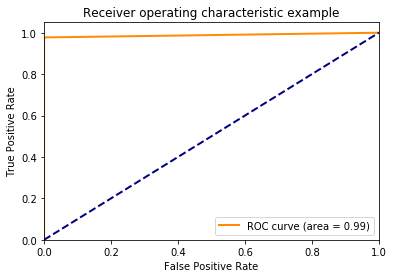

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# PR

In [24]:
# Compute PR curve and AP for each class
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(1-test_labels, prediction_scores_test[:, 0])
average_precision = average_precision_score(1-test_labels, prediction_scores_test[:, 0])

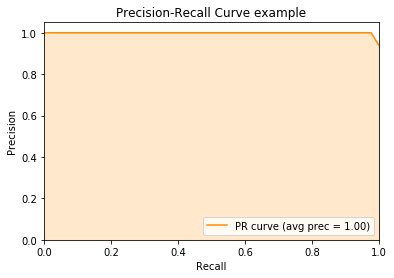

In [25]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
#plt.figure(figsize=(10,10))
lw = 2
plt.plot(recall, precision,'-',color='darkorange',label='PR curve (avg prec = %0.2f)' % average_precision)
#plt.step(recall[2], precision[2],color='darkorange',where='post',
#         label='PR curve (avg prec = %0.2f)' % average_precision[2])
plt.fill_between(recall, precision, alpha=0.2, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve example')
plt.legend(loc="lower right")
plt.show()

# Incorrect Predictions on train set

In [26]:
# Predictions_train = model.predict_classes(train_images)

In [27]:
# indices_incorrect_predictions_in_train = [i for i, x in enumerate(list(Predictions_train == train_labels.reshape(len(train_labels)))) if x == False ]
# print("Total Number of Incorrect Predictions among Train data : ", len(indices_incorrect_predictions_in_train))

In [28]:
# for k, idx in enumerate(indices_incorrect_predictions_in_train):
#     fig, (ax0, ax1) = plt.subplots(1,2, figsize =(10,10))
#     ax0.imshow(train_images[idx,:,:,0])
#     ax1.imshow(train_images[idx,:,:,1], cmap='jet')
#     plt.show()
#     print('Real Label : ', train_labels[idx])
#     print('Predicted Label : ', Predictions_train[idx])
# #     print('Target Criteria : ', train_target_criteria[idx])
# #     print('Ligand Criteria : ', train_ligand_criteria[idx])
# #     print('Ligand Criteria : ', train_Jaccard_criteria[idx])
#     if k > 30:
#         break

In [29]:
# Incorrect Predictions on test set

In [30]:
Predictions_test = model.predict_classes(test_images)

In [31]:
indices_incorrect_predictions_in_test = [i for i, x in enumerate(list(Predictions_test == test_labels.reshape(len(test_labels)))) if x == False ]
print("Total Number of Incorrect Predictions among Test data : ", len(indices_incorrect_predictions_in_test))

Total Number of Incorrect Predictions among Test data :  342


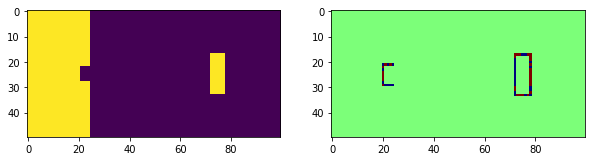

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  7
Ligand Criteria_size :  [17  7]
Jaccard_Similarity_Score :  [0.4666666666666667, 0.4]


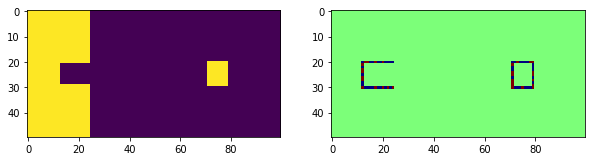

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  9
Ligand Criteria_size :  [11  9]
Jaccard_Similarity_Score :  mismatch


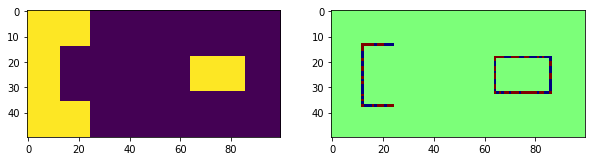

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [15 23]
Jaccard_Similarity_Score :  [0.48936170212765956, 0.425531914893617]


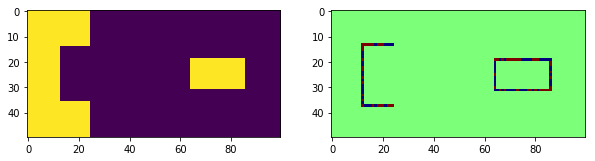

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [13 23]
Jaccard_Similarity_Score :  [0.44680851063829785, 0.46808510638297873]


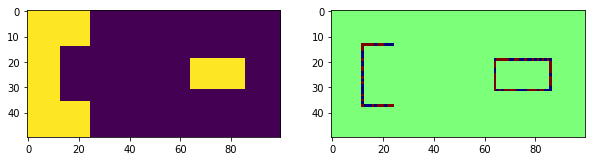

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [13 23]
Jaccard_Similarity_Score :  [0.44680851063829785, 0.44680851063829785]


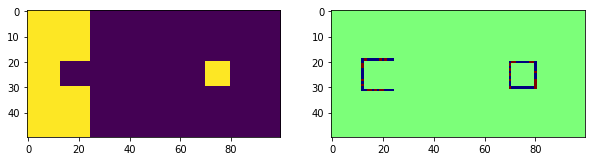

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [11 11]
Jaccard_Similarity_Score :  mismatch


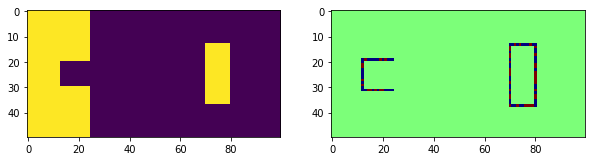

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [25 11]
Jaccard_Similarity_Score :  [0.42857142857142855, 0.4857142857142857]


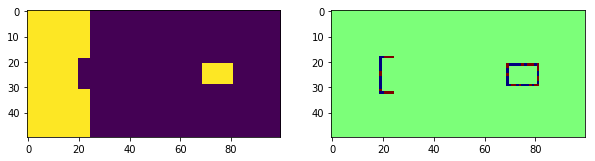

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [ 9 13]
Jaccard_Similarity_Score :  [0.4782608695652174, 0.4782608695652174]


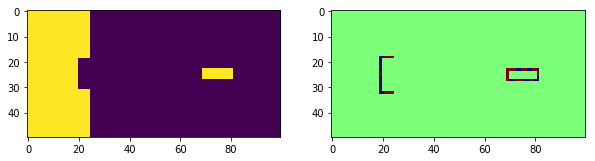

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [ 5 13]
Jaccard_Similarity_Score :  [0.34782608695652173, 0.391304347826087]


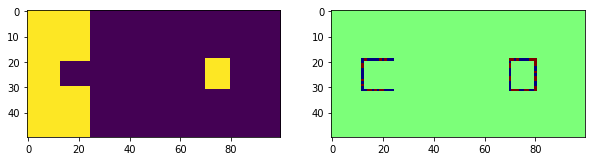

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [13 11]
Jaccard_Similarity_Score :  [0.4, 0.4857142857142857]


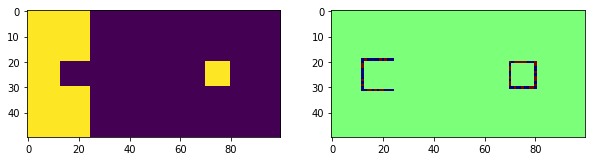

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [11 11]
Jaccard_Similarity_Score :  mismatch


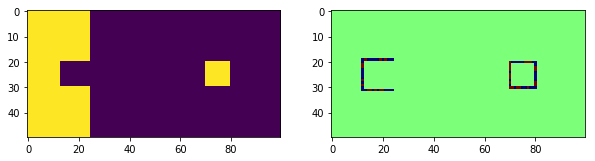

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [11 11]
Jaccard_Similarity_Score :  mismatch


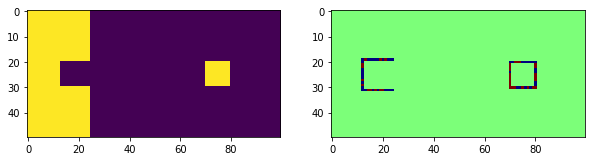

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  11
Ligand Criteria_size :  [11 11]
Jaccard_Similarity_Score :  mismatch


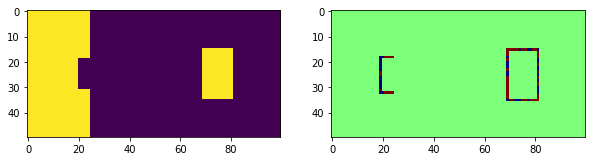

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [21 13]
Jaccard_Similarity_Score :  [0.391304347826087, 0.43478260869565216]


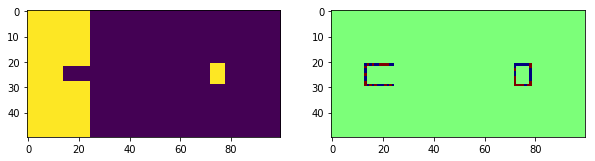

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  7
Ligand Criteria_size :  [9 7]
Jaccard_Similarity_Score :  mismatch


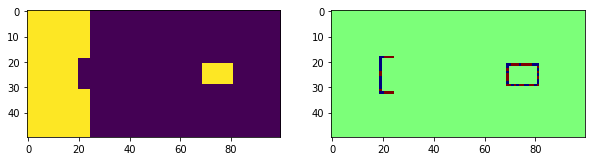

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [ 9 13]
Jaccard_Similarity_Score :  [0.43478260869565216, 0.4782608695652174]


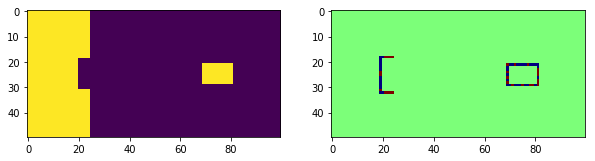

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [ 9 13]
Jaccard_Similarity_Score :  [0.391304347826087, 0.34782608695652173]


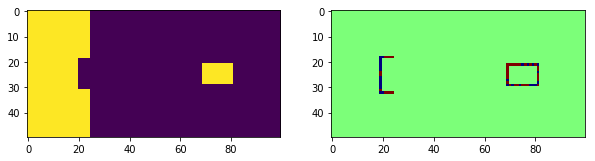

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [ 9 13]
Jaccard_Similarity_Score :  [0.43478260869565216, 0.391304347826087]


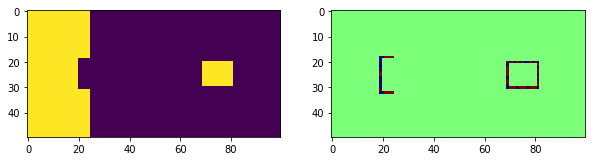

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  13
Ligand Criteria_size :  [11 13]
Jaccard_Similarity_Score :  [0.34782608695652173, 0.4782608695652174]


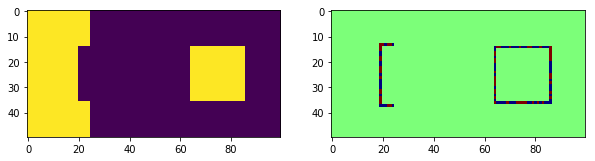

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [23 23]
Jaccard_Similarity_Score :  [0.2727272727272727, 0.42424242424242425]


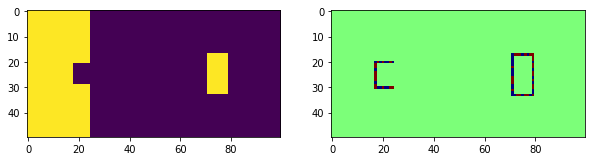

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  9
Ligand Criteria_size :  [17  9]
Jaccard_Similarity_Score :  [0.30434782608695654, 0.4782608695652174]


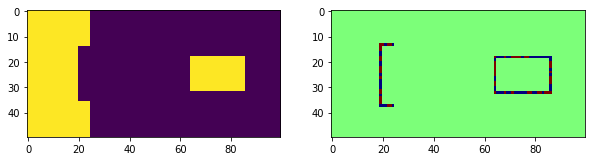

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [15 23]
Jaccard_Similarity_Score :  [0.45454545454545453, 0.45454545454545453]


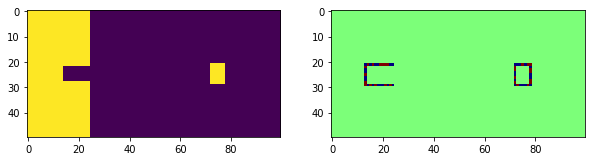

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  7
Ligand Criteria_size :  [9 7]
Jaccard_Similarity_Score :  mismatch


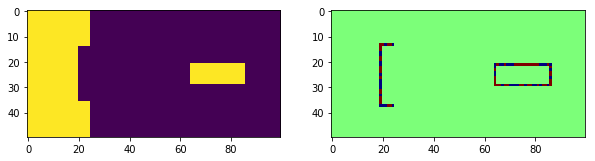

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [ 9 23]
Jaccard_Similarity_Score :  [0.45454545454545453, 0.45454545454545453]


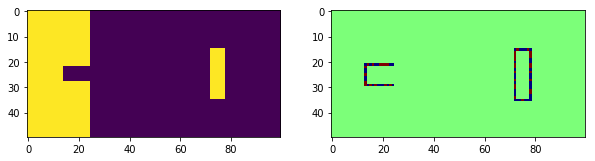

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  7
Ligand Criteria_size :  [21  7]
Jaccard_Similarity_Score :  [0.4827586206896552, 0.3793103448275862]


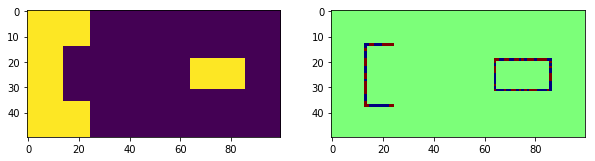

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [13 23]
Jaccard_Similarity_Score :  [0.4666666666666667, 0.4666666666666667]


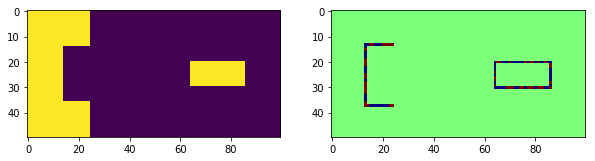

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [11 23]
Jaccard_Similarity_Score :  [0.4888888888888889, 0.35555555555555557]


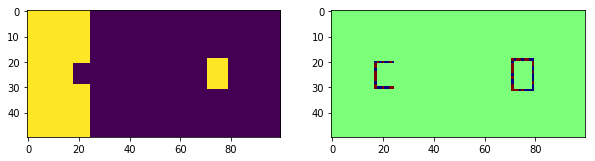

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  9
Ligand Criteria_size :  [13  9]
Jaccard_Similarity_Score :  [0.43478260869565216, 0.43478260869565216]


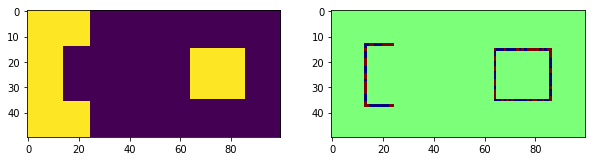

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [21 23]
Jaccard_Similarity_Score :  [0.4666666666666667, 0.4]


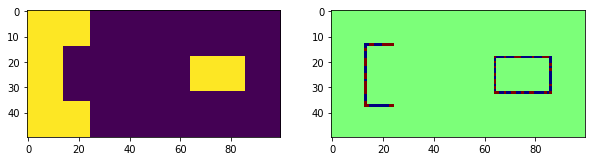

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [15 23]
Jaccard_Similarity_Score :  [0.4666666666666667, 0.4222222222222222]


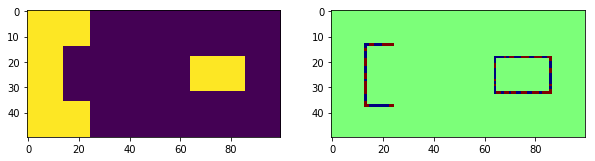

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  23
Ligand Criteria_size :  [15 23]
Jaccard_Similarity_Score :  [0.4444444444444444, 0.4666666666666667]


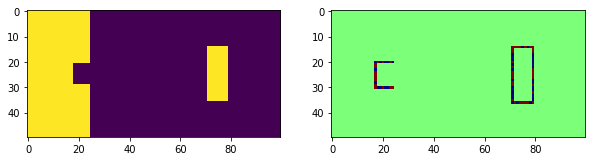

Real Label :  [0]
Predicted Label :  1
Target Criteria_size :  9
Ligand Criteria_size :  [23  9]
Jaccard_Similarity_Score :  [0.30434782608695654, 0.43478260869565216]


In [32]:
for k, idx in enumerate(indices_incorrect_predictions_in_test):
    fig, (ax0, ax1) = plt.subplots(1,2,figsize =(10,10))
    ax0.imshow(test_images[idx,:,:,0])
    ax1.imshow(test_images[idx,:,:,1], cmap='jet')
    plt.show()
    print('Real Label : ', test_labels[idx])
    print('Predicted Label : ', Predictions_test[idx])
    print('Target Criteria_size : ', test_target_criteria_size[idx])
    print('Ligand Criteria_size : ', test_ligand_criteria_size[idx])
    print('Jaccard_Similarity_Score : ', test_Jaccard_criteria[idx])
    if k > 30:
        break